# i. Perkenalan
Nama        : Nadia Nabilla Shafira

Batch       : HCK-009

Objectives  : Project ini bertujuan untuk memprediksi apakah seseorang akan gagal bayar atau tidak berdasarkan beberapa faktor menggunakan model terbaik di antara Logistic Regression, SVM, dan KNN.

```py
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "nadia-400309"
client = bigquery.Client(project=project_id)
```

# ii. Query SQL
Berikut merupakan query yang digunakan untuk mengambil data credit card default dari Google BigQuery.

``` py
df = client.query('''
SELECT 
      limit_balance,
      CAST(sex AS INT) AS sex,
      CAST(education_level AS INT) AS education_level,
      CAST(marital_status AS INT) AS marital_status,
      age,
      pay_0,
      pay_2,
      pay_3,
      pay_4,
      CAST(pay_5 AS FLOAT64) AS pay_5,
      CAST(pay_6 AS FLOAT64) AS pay_6,
      bill_amt_1,
      bill_amt_2,
      bill_amt_3,
      bill_amt_4,
      bill_amt_5,
      bill_amt_6,
      pay_amt_1, 
      pay_amt_2, 
      pay_amt_3, 
      pay_amt_4, 
      pay_amt_5, 
      pay_amt_6, 
      CAST(default_payment_next_month AS INT) AS default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 18000;
''').to_dataframe()
```

# iii. Import Libraries

In [1]:
import pandas as pd
import numpy as np

# Exploratory Data Analysis
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix

# Feature Engineering
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Data Modeling
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Model Evaluation
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

# Others
import warnings

# iv. Data Loading

Data yang digunakan merupakan data credit card default yang diperoleh dari Google BigQuery (https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=nadia-400309) dan kemudian disimpan dalam bentuk csv.

In [2]:
# load data
df = pd.read_csv('P1G5_Set_1_nadia_nabilla.csv')

In [3]:
# 10 data pertama
df.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


Tabel di atas merupakan 10 data teratas dari dataframe yang akan digunakan untuk pemodelan.

In [4]:
# 10 data terakhir
df.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


Tabel di atas merupakan 10 data terakhir dari dataframe yang akan digunakan untuk pemodelan.

In [5]:
# duplicate dataset
dfDuplicate = df.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Berdasarkan informasi di atas, dapat dilihat bahwa dataset ini memiliki 2965 entries dengan 24 kolom. Selain itu semua kolom bertipe data numerik (float dan integer). Pada output di atas juga dapat dinyatakan bahwa tidak terdapat missing values pada dataset ini karena banyaknya rows pada masing-masing kolom adalah 2965.

In [7]:
# duplication check
df.duplicated().sum()

1

Berdasarkan output di atas, terdapat 1 row data duplikat. Oleh karena itu, data duplikat tersebut akan dihapus.

In [8]:
df[df.duplicated(keep=False)]

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2806,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2815,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
df.drop_duplicates(keep='first', inplace=True)
df.duplicated().sum()

0

In [10]:
df.shape

(2964, 24)

Setelah menghapus 1 data yang duplikat, kini banyaknya entries adalah 2964.

## Data Cleaning

In [11]:
# mengubah nama kolom
df = df.rename(columns={'default_payment_next_month': 'default_payment',    #mengubah nama kolom 'default_payment_next_month' menjad 'default_payment'
                        'pay_0': 'pay_1'})                                  #mengubah nama kolom 'pay_0' menjadi 'pay_1'
df.head(1)

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1


Berdasarkan informasi dari website https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608, dapat diketahui bahwa label 0, 4, 5, dan 6 pada `education_level` berarti 'others'. Oleh karena itu, keempat label tersebut akan dijadikan 1 label, yaitu '4'.

In [12]:
fill = (df.education_level == 0) | (df.education_level == 5) | (df.education_level == 6)
df.loc[fill, 'education_level'] = 4

print(str(sorted(df['education_level'].unique())))

[1, 2, 3, 4]


# v. Exploratory Data Analysis

## Analisis Kolom Numerik

In [13]:
num = df[['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
        'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']]

### Statistik Deskriptif

In [14]:
num.describe()

,limit_balance,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
count,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2964.000000,2.964000e+03,2964.000000,2964.000000,2964.000000,2964.000000
mean,163356.950067,35.193657,52135.889001,50666.241228,48256.032726,44104.558367,40969.898448,39786.491228,6351.044872,6.274611e+03,5152.234818,4562.914980,4914.944332,5384.517544
std,125049.701016,9.110949,72334.536115,70790.828470,68151.445516,61912.600106,58276.878626,57308.498646,20888.933729,2.888432e+04,14289.177313,13283.476236,16736.920951,17278.585006
min,10000.000000,21.000000,-11545.000000,-67526.000000,-25443.000000,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3979.750000,3403.500000,3311.750000,2585.000000,1974.500000,1433.000000,1013.000000,9.975000e+02,479.250000,313.750000,325.250000,175.250000
50%,140000.000000,34.000000,24325.000000,23169.000000,21549.500000,19895.000000,18819.500000,18511.500000,2238.000000,2.182500e+03,1997.000000,1600.000000,1646.500000,1626.500000
75%,230000.000000,41.000000,69863.000000,67836.250000,63034.500000,58638.500000,53414.500000,52297.000000,5089.500000,5.000000e+03,4500.000000,4000.250000,4021.000000,4081.750000
max,800000.000000,69.000000,613860.000000,512650.000000,578971.000000,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000


Output di atas menunjukkan statistik deskriptif dari data yang dimiliki. Dapat dilihat bahwa kebanyakan kolom memiliki nilai maksimum jauh di atas Q3, hal ini merupakan indikasi adanya outlier dalam data.

### Distribusi Data

limit_balance     1.000098
age               0.772241
bill_amt_1        2.482972
bill_amt_2        2.456727
bill_amt_3        2.568258
bill_amt_4        2.446553
bill_amt_5        2.398729
bill_amt_6        2.430769
pay_amt_1        11.869892
pay_amt_2        29.384912
pay_amt_3         8.039392
pay_amt_4         8.446011
pay_amt_5        11.461365
pay_amt_6         9.753775
dtype: float64


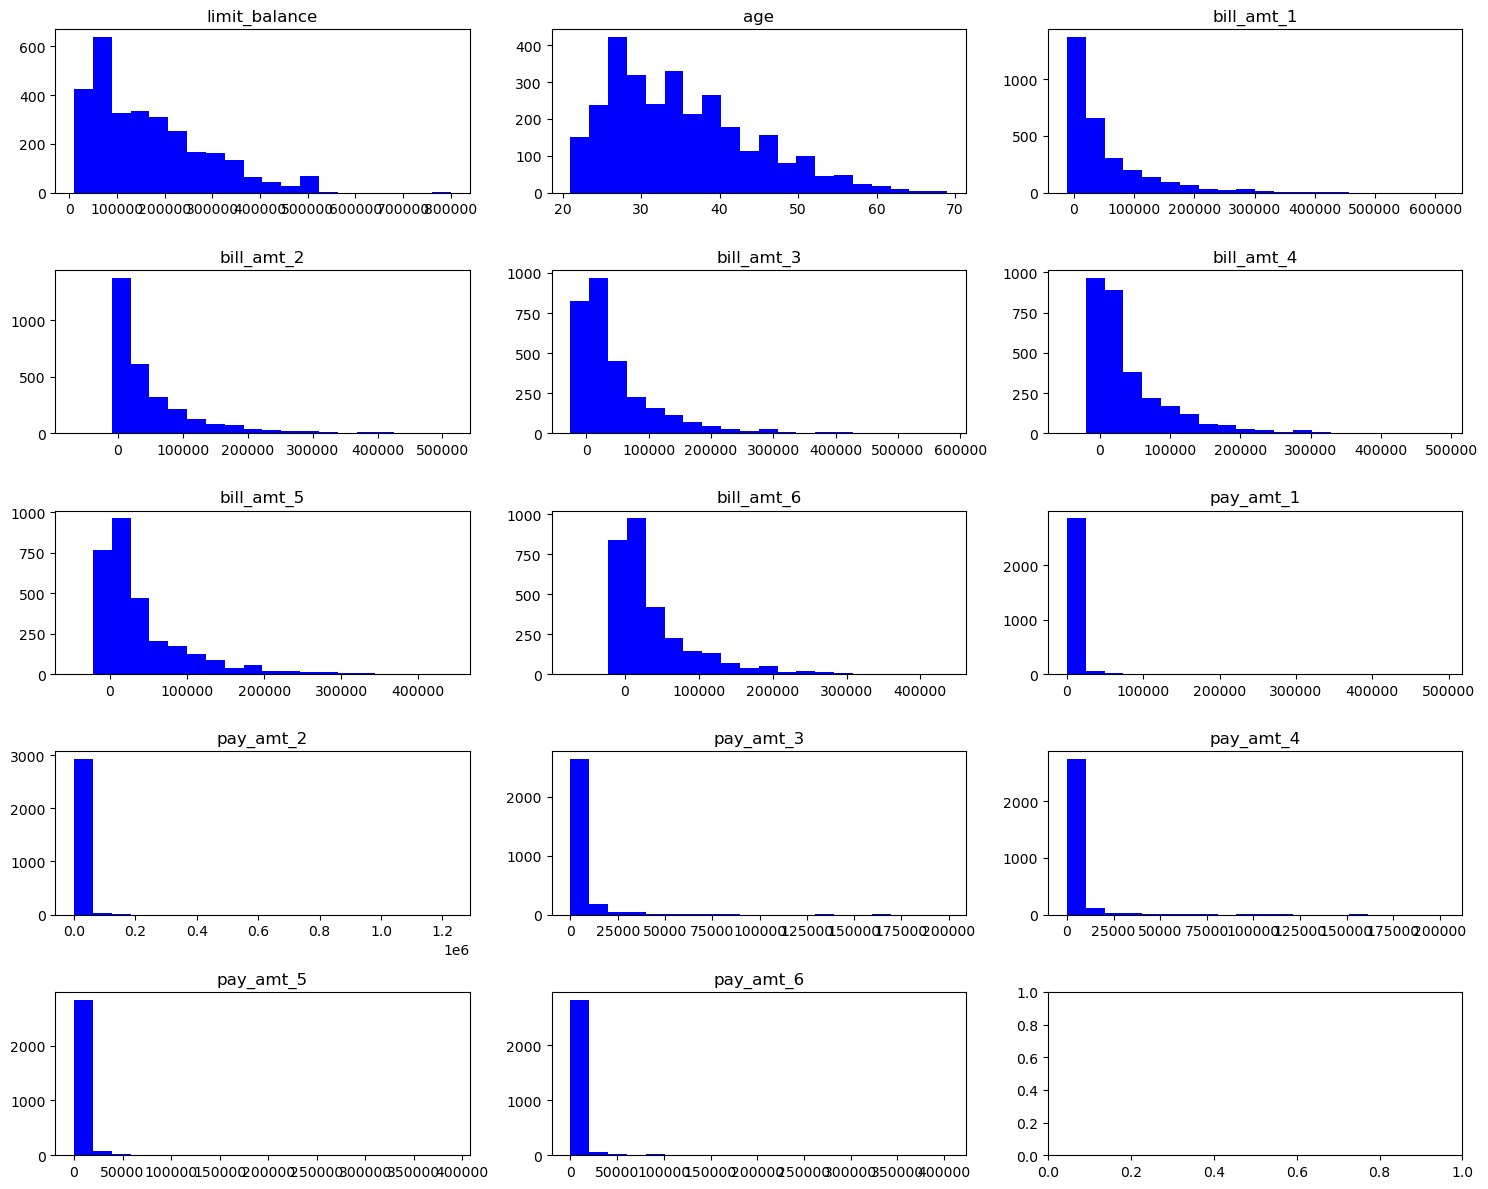

In [15]:
skewness = num.apply(lambda x: skew(x.dropna()))
print(skewness)

fig, axs = plt.subplots(5, 3, figsize = (15, 12))
axs = axs.flatten()

for i, col in enumerate(num):
    axs[i].hist(num[col], color='blue', bins = 20)
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

Berdasarkan informasi di atas, dapat dilihat bahwa semua kolom numerik pada dataset ini berdistribusi miring kanan/miring positive.

## Analisis Kolom Kategorik

### Default Payment

[Text(0, 0, '2329'), Text(0, 0, '635')]

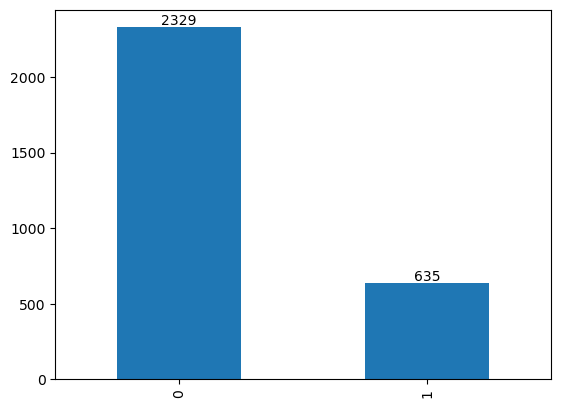

In [16]:
dfCount = df['default_payment'].value_counts().sort_index().plot(kind='bar')
dfCount.bar_label(dfCount.containers[0])

> Berdasarkan bar chart di atas, dapat dilihat bahwa dari 2964 data, terdapat 2329 yang tidak gagal bayar, dan 635 lainnya merupakan mereka yang gagal bayar.

### Sex

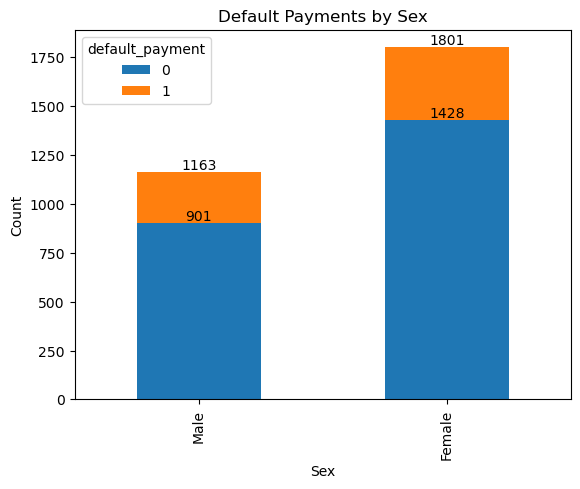

In [17]:
sexCount = df.groupby(['sex', 'default_payment']).size().unstack()

ax = sexCount.plot(kind='bar', stacked=True)

# menambah label untuk masing-masing segmen
for container in ax.containers:
    ax.bar_label(container)

# mengatur judul barchart, label x, dan label y
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.set_title('Default Payments by Sex')
plt.xticks([0, 1], ['Male', 'Female'])

plt.show()

In [18]:
sexCount

default_payment,0,1
sex,,
1,901,262
2,1428,373


> Berdasarkan stacked bar chart di atas, dapat dilihat bahwa sebanyak 901 dari 1163 pria, atau 77.47%, tidak gagal bayar, dan sisanya gagal bayar. Sedangkan untuk gender wanita, sebanyak 1428 dari 1801, atau 79.3%, orang tidak gagal bayar, dan sisanya gagal bayar.

Berdasarkan perbandingan antara pria dan wanita, persentase mereka yang tidak gagal bayar tidak jauh berbeda (77.47% dan 79.3%).

### Education Label

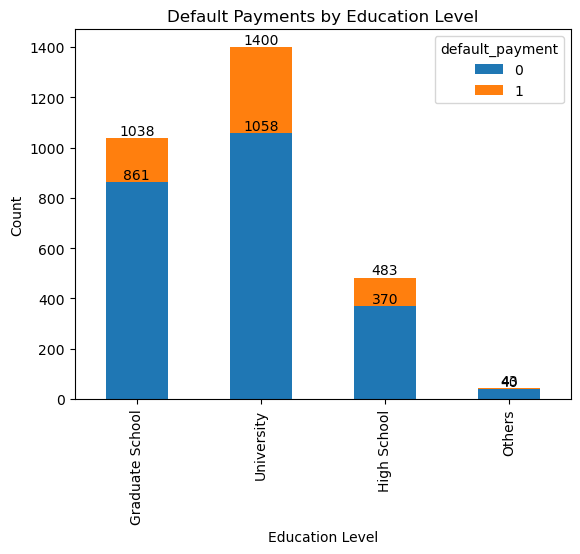

In [21]:
eduCount = df.groupby(['education_level', 'default_payment']).size().unstack()

ax = eduCount.plot(kind='bar', stacked=True)

for container in ax.containers:
    ax.bar_label(container)

ax.set_xlabel('Education Level')
ax.set_ylabel('Count')
ax.set_title('Default Payments by Education Level')
plt.xticks([0, 1, 2, 3], ['Graduate School', 'University', 'High School', 'Others'])

plt.show()

In [20]:
eduCount

default_payment,0,1
education_level,,
1,861,177
2,1058,342
3,370,113
4,40,3


> Berdasarkan stacked bar chart di atas, dapat dilihat bahwa sebanyak 861 dari 1038 clients dengan pendidikan graduate school (magister), atau 82.96%, tidak gagal bayar, dan sisanya gagal bayar. Adapun clients dengan pendidikan university (master), terdapat 1058 dari 1400 (75.57%) dari mereka yang tidak gagal bayar, dan sisanya gagal bayar. Sedangkan untuk yang pendidikannya high school (SMA), sebanyak 370 dari 483, atau 76.40%, orang tidak gagal bayar, dan sisanya gagal bayar. Dan terdapat 40 dari 43 yang latar belakang pendidikannya tidak diketahui (93.02%) tidak gagal bayar, dan sisanya gagal bayar.

Berdasarkan perbandingan latar belakang pendidikan di atas, untuk yang diketahui latar belakang pendidikannya, persentase mereka yang tidak gagal bayar tertinggi adalah mereka yang berpendidikan graduate school, kemudian yang tertinggi kedua adalah high school, dan yang terakhir adalah university.

### Marital Status

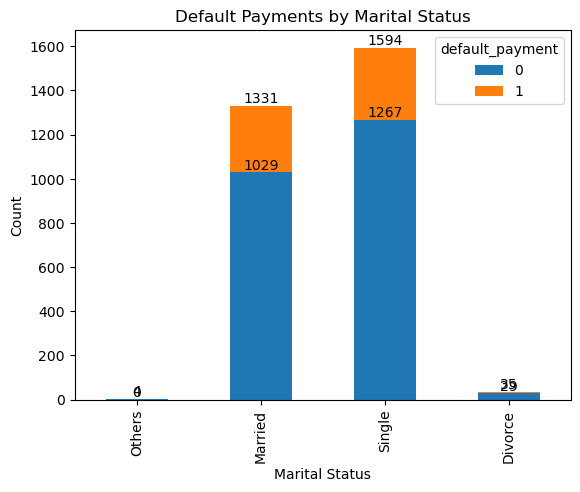

In [22]:
MSCount = df.groupby(['marital_status', 'default_payment']).size().unstack()

ax = MSCount.plot(kind='bar', stacked=True)

for container in ax.containers:
    ax.bar_label(container)

ax.set_xlabel('Marital Status')
ax.set_ylabel('Count')
ax.set_title('Default Payments by Marital Status')
plt.xticks([0, 1, 2, 3], ['Others', 'Married', 'Single', 'Divorce'])

plt.show()

In [23]:
MSCount

default_payment,0,1
marital_status,,
0,4.0,NaN
1,1029.0,302.0
2,1267.0,327.0
3,29.0,6.0


> Berdasarkan stacked bar chart di atas, dapat dilihat bahwa sebanyak 4 dari 4 (100%) clients yang tidak diketahui status pernikahannya dinyatakan tidak gagal bayar. Adapun clients yang berstatus menikah, terdapat 1029 dari 1331 (77.33%) dari mereka yang tidak gagal bayar, dan sisanya gagal bayar. Sedangkan untuk yang belum menikah, sebanyak 1267 dari 1594, atau 79.48%, orang tidak gagal bayar, dan sisanya gagal bayar. Dan terdapat 29 dari 35 yang bercerai (82.86%) tidak gagal bayar, dan sisanya gagal bayar.

Berdasarkan perbandingan status pernikahan di atas, untuk yang diketahui statusnya, persentase mereka yang tidak gagal bayar tertinggi adalah mereka yang berstatus cerai, kemudian yang tertinggi kedua adalah mereka yang belum menikah, dan yang terakhir adalah berstatus menikah.

## Korelasi

### Korelasi Kolom Numerik dengan default_payment

<Axes: >

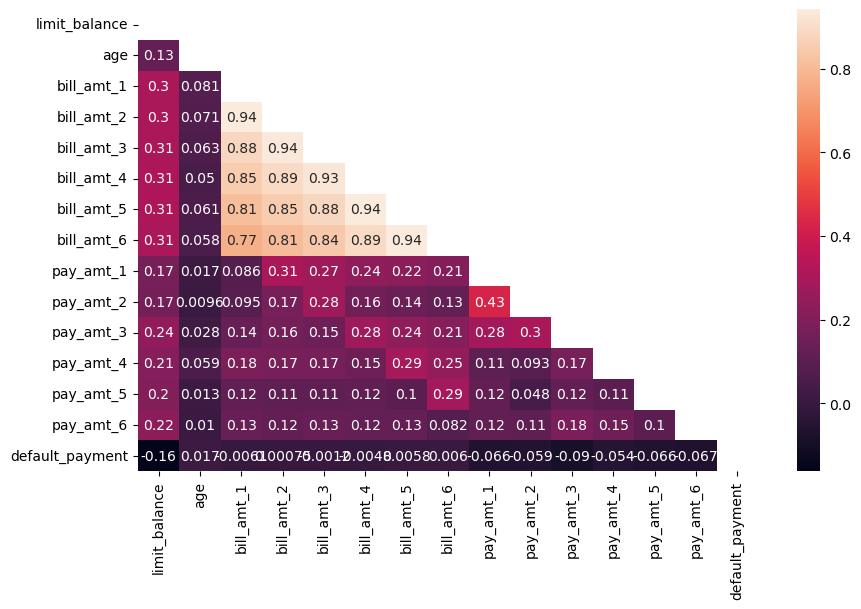

In [24]:
dfNum = df[['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
            'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment']]

plt.figure(figsize=(10,6))
sns.heatmap(dfNum.corr(),annot=True, mask=np.triu(dfNum.corr(method='spearman')))

Berdasarkan heatmap korelasi di atas, dapat dilihat bahwa hanya variabel `limit_balance` yang memiliki korelasi dengan variabel `default_payment`.

### Korelasi Kolom Kategorik dengan default_payment

In [25]:
dfCat = df[['sex', 'education_level', 'marital_status', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'default_payment']]
interval_cols = ['default_payment']

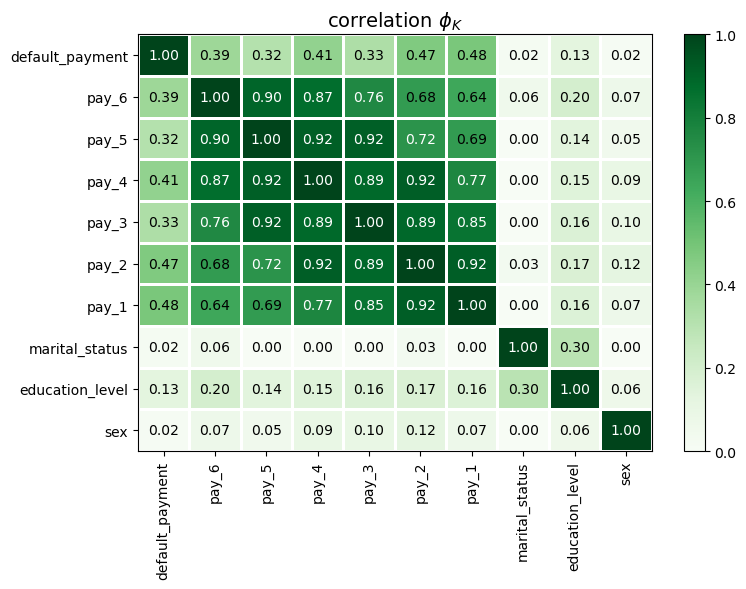

In [29]:
phik_overview = dfCat.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1,
                        figsize=(8, 6))
plt.tight_layout()

Berdasarkan heatmap yang memuat informasi korelasi di atas, dapat dilihat bahwa hanya status pembayaran perbulan (`pay_1` hingga `pay_6`) dan tingkat pendidikan (`education_level`) yang berkorelasi dengan keputusan gagal bayar atau tidak.

# vi. Feature Engineering

## Splitting Features dan Target
> Tahap ini memuat proses pemisahan features dengan target. Di mana pada dataset ini, features merupakan seluruh kolom yang ada kecuali kolom `default_payment`, karena kolom `default_payment` merupakan target pada analisis ini.

In [30]:
X = df.drop(['default_payment'], axis = 1)    #features (X) terdiri tadi seluruh kolom, kecuali kolom 'default_payment'
y = df['default_payment']                     #target (y) pada project ini adalah 'default_payment'

## Feature Selection
> Feature selection dilakukan untuk memilih feature mana yang tepat untuk dimasukkan ke dalam model. Feature selection dapat dilakukan berdasarkan personal judgement, domain dan business knowledge, korelasi, dan VIF (untuk model linear).

### Berdasarkan Korelasi
> Pada bagian ini, akan dilakukan feature selection berdasarkan nilai korelasi. Di mana feature yang tidak berkorelasi dengan target (`default_payment`) akan dihapus. Ada pun nilai korelasi dapat dilihat pada tahap Exploratory Data Analysis (EDA).

In [31]:
X = X.drop(['age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
            'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'marital_status', 'sex'],axis=1)
print('Dimensi dataset  :', X.shape)

Dimensi dataset  : (2964, 8)


### Berdasarkan Nilai VIF
> Dalam melakukan pemodelan dengan model linear, maka asumsi multikolinearitas harus terpenuhi untuk memastikan tidak adanya hubungan linear antar feature.

In [32]:
# membuat function untuk menghitung nilai VIF
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [33]:
calc_vif(X)

,variables,VIF
0,limit_balance,2.104985
1,education_level,1.967606
2,pay_1,1.867673
3,pay_2,3.135195
4,pay_3,3.410120
5,pay_4,4.081252
6,pay_5,4.811427
7,pay_6,3.220370


Berdasarkan output di atas, terlihat bahwa nilai VIF < 10, artinya tidak terdapat permasalahan multikolinearitas. Sehingga, setelah melakukan feature selection, kini terdapat 8 features yang akan diolah untuk membuat model.

## Splitting Data Train dan Data Test

In [34]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3, random_state = 46, stratify=y)   #perbandingan training dan testing -> 70:30
print('Size X Train', XTrain.shape)
print('Size X Test', XTest.shape)

Size X Train (2074, 8)
Size X Test (890, 8)


Dengan perbandingan 70:30, banyaknya data pada data train yaitu sebanyak 2074 dan banyaknya data pada data test yaitu sebanyak 890.

## Outlier Detecting
> Pada tahap ini akan dilakukan pendeteksian outlier pada feature numerik.

<Axes: >

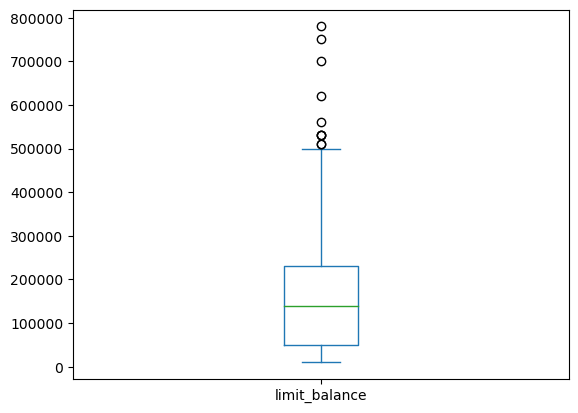

In [35]:
XTrain['limit_balance'].plot(kind='box')

Berdasarkan boxplot di atas, dapat dilihat bahwa terdapat outlier pada feature `limit_balance`.

## Feature Transformation & Outlier Handling

In [36]:
numCol = ['limit_balance']
num_pipeline = make_pipeline(Winsorizer(capping_method='iqr', tail='right', fold=1.5),   #outlier handling pada feature numerik dengan Winsorizer
                             RobustScaler())                                             #scaling feature numerik dengan RobustScaler()

prep = ColumnTransformer([
    ('numerik', num_pipeline, numCol)],                                                  #feature numerik akan discale
    remainder='passthrough')                                                             #feature lainnya tidak akan ditransformasi

# vii. Model Definition

Pada analisis ini akan dilakukan pemodelan menggunakan 3 model klasifikasi, yakni logistic regression, SVM, dan KNN, yang nantinya akan dipilih 1 yang terbaik.
- Logistic Regression merupakan model klasifikasi dengan proses kerja yang mirip dengan linear regression.
- SVM merupakan model klasifikasi yang mengelompokkan sebaran data dengan decision boundary (hyperplane). Pada model SVM, terdapat beberapa kernel yang dapat digunakan, salah satunya adalah **RBF Kernel**. RBF Kernel merupakan kernel yang cocok digunakan ketika tidak terdapat informasi mengenai distribusi datanya. Selain itu, kernel ini memisahkan data yang kompleks untuk diklasifikasikan menjadi dua kelompok.
- KNN merupakan model klasifikasi yang mengelompokkan data berdasarkan jarak data test dengan data trainnya. Pada model KNN, terdapat hyperparameter **K**, di mana K merupakan banyaknya data train terdekat dari data test. Untuk melakukan klasifikasi menggunakan KNN, diperlukan nilai K yang ganjil, agar dapat diputuskan jarak terdekatnya ketika terdpat jarak yang sama.

In [37]:
# logistics regression
logreg = make_pipeline(prep, LogisticRegression())

# SVM
svm = make_pipeline(prep, SVC())

# KNN
knn = make_pipeline(prep, KNeighborsClassifier())

# viii. Model Training

In [38]:
# Logistic Regression
warnings.filterwarnings('ignore')
logreg.fit(XTrain, yTrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerik',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['limit_balance'])])),
                ('logisticregression', LogisticRegression())])

In [39]:
# SVM
svm.fit(XTrain, yTrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerik',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['limit_balance'])])),
                ('svc', SVC())])

In [40]:
# KNN
knn.fit(XTrain, yTrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerik',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['limit_balance'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

# ix. Model Evaluation

Untuk mengevaluasi model klasifikasi, dapat dilakukan dengan melihat nilai accuracy, precision, recall, ataupun f1 score.
- **Accuracy** merupakan nilai yang menunjukkan seberapa banyak data yang diprediksi benar oleh model. Semakin tinggi nilai accuracy (mendekati 100%), maka model yang terbentuk juga semakin baik. Akan tetapi, accuracy kurang cocok digunakan untuk imbalanced data, karena akan menghasilkan interpretasi yang keliru.
- **Precision** menunjukkan persentase data yang diprediksi benar dari keseluruhan data yang positif. Precision cocok digunakan ketika ingin meminimalisir False Positive (data yang diprediksi positif, padahal sebenarnya negatif).
- **Recall** merupakan nilai yang menunjukkan seberapa banyak data yang diprediksi benar positif dari keseluruhan data yang benar positif. Recall cocok digunakan ketika ingin meminimalisir False Negatif (data yang diprediksi negatif, padahal sebenarnya positif).
- **F1-Score** merupakan harmonic mean dari precision dan recall. F1-Score yang tinggi mengindikasikan bahwa model klasifikasi memiliki precision dan recall yang baik.

Untuk memprediksi apakah seseorang akan gagal bayar atau tidak, dapat dilihat nilai **_recall/f1-score_** pada kelas 'gagal bayar' (1).

## Model Prediction

In [41]:
# logreg prediction
yPredTrain_logreg = logreg.predict(XTrain)
yPredTest_logreg = logreg.predict(XTest)

# svm prediction
yPredTrain_svm = svm.predict(XTrain)
yPredTest_svm = svm.predict(XTest)

# knn prediction
yPredTrain_knn = knn.predict(XTrain)
yPredTest_knn = knn.predict(XTest)

## Evaluation Score

### Logistic Regression

In [42]:
print('logistic regression train evaluation score')
print(classification_report(yTrain, yPredTrain_logreg))
print('logistic regression test evaluation score')
print(classification_report(yTest, yPredTest_logreg))

logistic regression train evaluation score
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1630
           1       0.77      0.32      0.45       444

    accuracy                           0.83      2074
   macro avg       0.80      0.65      0.68      2074
weighted avg       0.83      0.83      0.81      2074

logistic regression test evaluation score
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       699
           1       0.73      0.29      0.41       191

    accuracy                           0.82       890
   macro avg       0.78      0.63      0.66       890
weighted avg       0.81      0.82      0.79       890



> Berdasarkan hasil klasifikasi menggunakan regresi logistik, pada data train, diperoleh nilai f1-score adalah 45%. Artinya model regresi logistik dapat memprediksi dengan benar seseorang gagal membayar tagihan sebesar 45%.

> Sedangkan pada data test, diperoleh nilai f1-score adalah 41%. Artinya model regresi logistik dapat memprediksi dengan benar seseorang gagal membayar tagihan sebesar 41%.

> Dengan membandingkan f1-score pada data train dan data test, dapat diketahui bahwa model yang terbentuk overfit, karena pada data train model dapat memprediksi lebih baik daripada pada data test.

### SVM

In [43]:
print('svm evaluation train score')
print(classification_report(yTrain, yPredTrain_svm))
print('svm evaluation test score')
print(classification_report(yTest, yPredTest_svm))

svm evaluation train score
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1630
           1       0.77      0.41      0.54       444

    accuracy                           0.85      2074
   macro avg       0.81      0.69      0.72      2074
weighted avg       0.84      0.85      0.83      2074

svm evaluation test score
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       699
           1       0.68      0.35      0.46       191

    accuracy                           0.83       890
   macro avg       0.76      0.65      0.68       890
weighted avg       0.81      0.83      0.80       890



> Berdasarkan hasil klasifikasi menggunakan *Support Vector Machine* (SVM), pada data train, diperoleh nilai f1-score adalah 54%. Artinya model SVM dapat memprediksi dengan benar seseorang gagal membayar tagihan sebesar 54%.

> Sedangkan pada data test, diperoleh nilai f1-score adalah 46%. Artinya model SVM dapat memprediksi dengan benar seseorang gagal membayar tagihan sebesar 46%.

> Dengan membandingkan f1-score pada data train dan data test, dapat diketahui bahwa model yang terbentuk overfit, karena pada data train model dapat memprediksi lebih baik daripada pada data test.

### KNN

In [44]:
print('knn evaluation train score')
print(classification_report(yTrain, yPredTrain_knn))
print('knn evaluation test score')
print(classification_report(yTest, yPredTest_knn))

knn evaluation train score
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1630
           1       0.74      0.49      0.59       444

    accuracy                           0.85      2074
   macro avg       0.81      0.72      0.75      2074
weighted avg       0.84      0.85      0.84      2074

knn evaluation test score
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       699
           1       0.55      0.39      0.46       191

    accuracy                           0.80       890
   macro avg       0.70      0.65      0.67       890
weighted avg       0.78      0.80      0.79       890



> Berdasarkan hasil klasifikasi menggunakan *K-Nearest Neighbors* (KNN), pada data train, diperoleh nilai f1-score adalah 59%. Artinya model KNN dapat memprediksi dengan benar seseorang gagal membayar tagihan sebesar 59%.

> Sedangkan pada data test, diperoleh nilai f1-score adalah 46%. Artinya model KNN dapat memprediksi dengan benar seseorang gagal membayar tagihan sebesar 46%.

> Dengan membandingkan f1-score pada data train dan data test, dapat diketahui bahwa model yang terbentuk overfit, karena pada data train model dapat memprediksi lebih baik daripada pada data test.

Berdasarkan ketiga model di atas, dapat dilihat bahwa model-model tersebut cenderung overfit. Walaupun logistic regression memiliki selisih nilai f1-score paling kecil. Namun jika dilihat f1-scorenya, model dengan nilai f1-score tertinggi pada data train adalah KNN. Artinya model KNN merupakan yang terbaik saat model diterapkan pada data yang sudah dilatih. Sedangkan model dengan f1-score tertinggi pada data test adalah SVM. Artinya SVM lebih mampu memprediksi data yang tidak terlihat dibanding dengan model lainnya.

Selain itu, berdasarkan nilai recall, model SVM lebih balance dibandingkan dengan model KNN. Ada pun model logistic regression tidak dipilih karena nilai recall yang kecil.

## Cross Validation

### Logistic Regression

In [45]:
logreg_crossVal = cross_val_score(logreg, XTrain, yTrain, cv=5, scoring='f1')

print('F1-Score Cross Validation  : ', logreg_crossVal)
print('Mean F1-Score Cross Validation : ', logreg_crossVal.mean())
print('Std F1-Score Cross Validation  : ', logreg_crossVal.std())

F1-Score Cross Validation  :  [0.416      0.35       0.54961832 0.453125   0.42622951]
Mean F1-Score Cross Validation :  0.43899456576148166
Std F1-Score Cross Validation  :  0.06488299283012709


Setelah melakukan cross validation, diperoleh rata-rata f1-score dari logistic regression adalah 43.9% dengan standard deviasi 0.06, artinya nilai dari masing-masing f1-scorenya tidak merentang jauh.

### SVM

In [209]:
svm_crossVal = cross_val_score(svm, XTrain, yTrain, cv=5, scoring='f1')

print('F1-Score Cross Validation  : ', svm_crossVal)
print('Mean F1-Score Cross Validation : ', svm_crossVal.mean())
print('Std F1-Score Cross Validation  : ', svm_crossVal.std())

F1-Score Cross Validation  :  [0.50724638 0.48484848 0.63087248 0.46268657 0.52238806]
Mean F1-Score Cross Validation :  0.5216083943494454
Std F1-Score Cross Validation  :  0.058255624978576975


Setelah melakukan cross validation, diperoleh rata-rata f1-score dari SVM adalah 52.16% dengan standard deviasi 0.058, artinya nilai dari masing-masing f1-scorenya tidak merentang jauh.

### KNN

In [211]:
knn_crossVal = cross_val_score(knn, XTrain, yTrain, cv=5, scoring='f1')

print('F1-Score Cross Validation  : ', knn_crossVal)
print('Mean F1-Score Cross Validation : ', knn_crossVal.mean())
print('Std F1-Score Cross Validation  : ', knn_crossVal.std())

F1-Score Cross Validation  :  [0.47945205 0.4057971  0.55128205 0.41958042 0.48717949]
Mean F1-Score Cross Validation :  0.4686582228571508
Std F1-Score Cross Validation  :  0.05224249692099835


Setelah melakukan cross validation, diperoleh rata-rata f1-score dari KNN adalah 46.86% dengan standard deviasi 0.052, artinya nilai dari masing-masing f1-scorenya tidak merentang jauh.

Berdasarkan hasil cross validation di atas, dapat dilihat bahwa SVM merupakan model dengan rata-rata f1-score tertinggi, yaitu 52.16%. Oleh karena itu, akan model SVM merupakan model yang paling baik.

## SVM Model Improvement

### Hyperparameter Tuning

In [ ]:
params_svm = {
    'svc__kernel':['poly', 'rbf'],
    'svc__degree':[2, 3],
    'svc__C':[0.1, 1, 10, 100],
    'svc__gamma':[0.1, 'scale'],
    'svc__class_weight':['balanced']}

grid_svm = GridSearchCV(estimator=svm, param_grid=params_svm, cv=3, n_jobs=-1, verbose=10, scoring='f1')
grid_svm.fit(XTrain, yTrain)

In [47]:
grid_svm.best_params_

{'svc__C': 0.1,
 'svc__class_weight': 'balanced',
 'svc__degree': 2,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf'}

In [48]:
svm_best = grid_svm.best_estimator_
svm_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerik',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['limit_balance'])])),
                ('svc', SVC(C=0.1, class_weight='balanced', degree=2))])

### Model Evaluation setelah Hyperparameter Tuning

In [49]:
yPredTrain_grid_svm = grid_svm.predict(XTrain)
yPredTest_grid_svm = grid_svm.predict(XTest)

In [50]:
print('svm evaluation train score')
print(classification_report(yTrain, yPredTrain_grid_svm))
print('svm evaluation test score')
print(classification_report(yTest, yPredTest_grid_svm))

svm evaluation train score
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1630
           1       0.57      0.57      0.57       444

    accuracy                           0.81      2074
   macro avg       0.72      0.72      0.72      2074
weighted avg       0.81      0.81      0.81      2074

svm evaluation test score
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       699
           1       0.55      0.51      0.53       191

    accuracy                           0.81       890
   macro avg       0.71      0.70      0.70       890
weighted avg       0.80      0.81      0.80       890



Berdasarkan hasil di atas, dapat dilihat bahwa f1 score baik pada data train dan data test meningkat setelah dilakukan hyperparameter tuning. Pada data train, f1-score meningkat dari 54% menjadi 57%. Sedangkan pada data test, f1-score meningkat dari 46% menjadi 53%.

# x. Model Saving

In [51]:
import pickle

with open('best_svm.pkl', 'wb') as model:
  pickle.dump(svm_best, model)

# xi. Model Inference
> Model Inference akan dilakukan pada file 'Inference_P1G5_Set_1_nadia_nabilla.ipynb'

# xii. Kesimpulan

Setelah melakukan pemodelan untuk memprediksi apakah seseorang akan gagal bayar atau tidak, diperoleh 1 model terbaik, yaitu SVM. Kemudian untuk mendapatkan performa model SVM yang lebih baik, dilakukan hyperparameter tuning untuk mengetahui hyperparameter apa saja yang digunakan. Dan diketahui model SVM yang terbaik dalam memprediksi seseorang gagal bayar atau tidak adalah model SVM yang diset 'balanced' untuk mengatasi permasalahan imbalanced data, dan dengan kernel RBF, C 0.1, dan gamma 'scale'.

Setelah dilakukan hyperparameter tuning, diperoleh f1-score pada masing-masing data train dan data test adalah 57% dan 53%. Sedangkan nilai recallnya adalah 57% dan 51%.

# Conceptual Problems

1. Apa yang dimaksud dengan coefficient pada logistic regression?

Coefficient merupakan nilai yang merepresentasikan bagaimana perubahan variabel bebas/feature memengaruhi peluang terjadinya sesuatu (target).

--------

2. Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang anda pahami!

Untuk mengklasifikasikan dataset, perlu dilakukan pemisahan data dengan decision boundary. Untuk menentukan apakah decision boundary akan mengikuti garis linear, polinomial, atau lainnya dapat ditentukan dengan kernel. Terdapat beberapa kernel yang dapat digunakan, salah satunya adalah **RBF Kernel**. RBF Kernel merupakan kernel yang cocok digunakan ketika tidak terdapat informasi mengenai distribusi datanya. Selain itu, kernel ini memisahkan data yang kompleks untuk diklasifikasikan menjadi dua kelompok.

--------------------

3. Bagaimana cara memilik `K` yang optimal pada KNN?

Dalam menentukan nilai K, dapat dilakukan dengan **trial and error**. Atau dapat dilakukan menggunakan Grid Search, di mana kita dapat membuat list dari nilai K, kemudian dengan Grid Search, akan ditemukan model yang terbaik dengan nilai K yang optimal.

-----------

4. Apa yang dimaksud dengan metics-metrics berikut: `Accuracy`, `Precision`, `Recall`, `F1 Score`, dan kapan waktu yang tepat untuk menggunakannya?

Untuk mengevaluasi model klasifikasi, dapat dilakukan dengan melihat nilai accuracy, precision, recall, ataupun f1 score.
- **`Accuracy`** merupakan nilai yang menunjukkan seberapa banyak data yang diprediksi benar oleh model. Semakin tinggi nilai accuracy (mendekati 100%), maka model yang terbentuk juga semakin baik. Akan tetapi, accuracy kurang cocok digunakan untuk imbalanced data, karena akan menghasilkan interpretasi yang keliru.
- **`Precision`** menunjukkan persentase data yang diprediksi benar dari keseluruhan data yang positif. Precision cocok digunakan ketika ingin meminimalisir False Positive (data yang diprediksi positif, padahal sebenarnya negatif).
- **`Recall`** merupakan nilai yang menunjukkan seberapa banyak data yang diprediksi benar positif dari keseluruhan data yang benar positif. Recall cocok digunakan ketika ingin meminimalisir False Negatif (data yang diprediksi negatif, padahal sebenarnya positif).
- **`F1-Score`** merupakan harmonic mean dari precision dan recall. F1-Score yang tinggi mengindikasikan bahwa model klasifikasi memiliki precision dan recall yang baik.